In [1]:
# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import PHILIPS2LBOTTLE, PHILIPS1L5BOTTLE, PIQTSP
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import qa_date, scanner_operator, larmor_frequency

def show_test_result(passed):
    colour, status = 'green', 'ACCEPTABLE' if passed else 'red', 'FAILED'
    return HTMLLatex(
        f'<b>Test Result - <span style="color:{colour}">{status}</span></b>',
        f'\\textbf{{Test Result -- \\color{{{colour}}}{status}}}'
    )


# Watermark
wm = watermark()
display(pd.DataFrame(
    {'Watermark': list(wm.values())},
    index=wm.keys()
))

Watermark
CalculationTime  2022-03-31T15:13:57+01:00
User                        birchhub/rtrhd
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.11
dcmextras                            0.2.6
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

# Summary
Tests Performed:

- Slice shape and Profile
- Distortion and Field of View
- Resolution
- Ghosting
- Head Coil Image Uniformity
- Head Coil SNR
- Long-term Stability

----

All of the above are acceptable.

----

### Details of series to analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid
series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')

display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner     PHILIPS-VL9UFAM
Date               20210318
Patient  AQA20210318NBTMR12
Study             663860893

In [3]:
text = f'''
{operator}
Medical Physics & Bioengineering, UH Bristol
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))

In [4]:
NewPage

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo using the crossed _slice profile_ slots in the PIQT phantom.

### 3 mm Slice

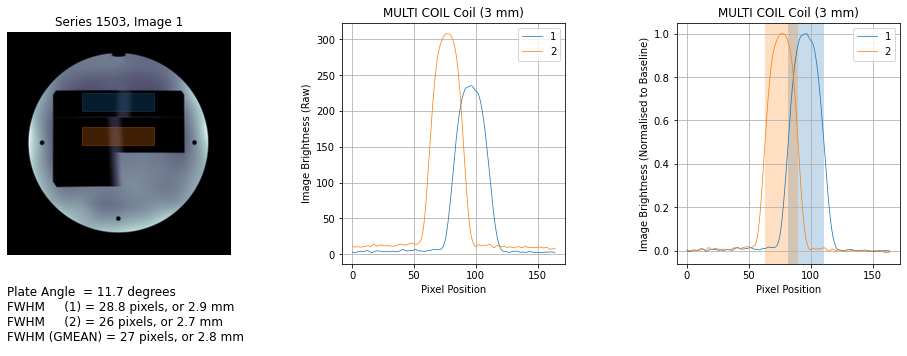

In [5]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobj = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
results = slice_profile_report(dobj, frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

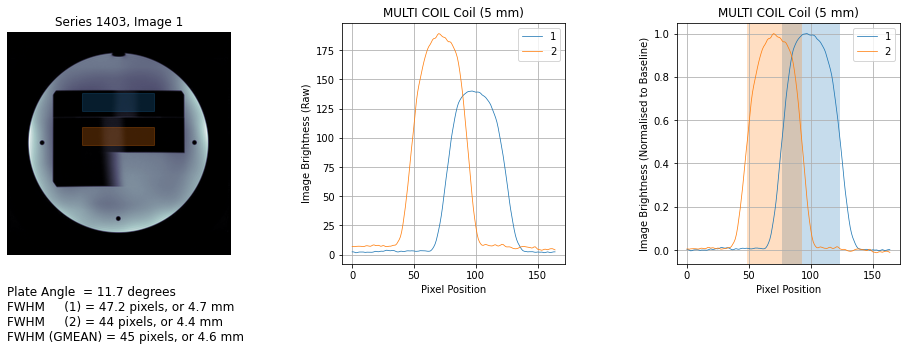

In [6]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slice_isx = info['Series']['5mm'], info['Slice']['5mm']

dobj = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
result = slice_profile_report(dobj, frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [7]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                27.7             2.8
5.0                                45.7             4.6

These profile widths are well within the AAPM tolerance of 0.5mm. The variation between profiles 1 and 2 for both slice widths, and the clipping of the profiles of the more central channel, are an artefact of minor mispositioning of the phantom.

In [8]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are before and after applying Philips 2D distortion correction.

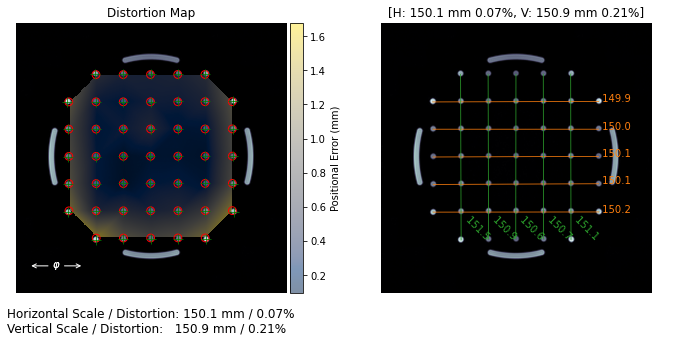

In [9]:
# PIQT: Distortion : SE Axial, Phase RL, 512 matrix (Uncorrected)
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

seriesno, frame = series['AxialRL_Uncorrected'], slices['AxialRL_Uncorrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = piqt_distortion_report(dobj, frame=frame)

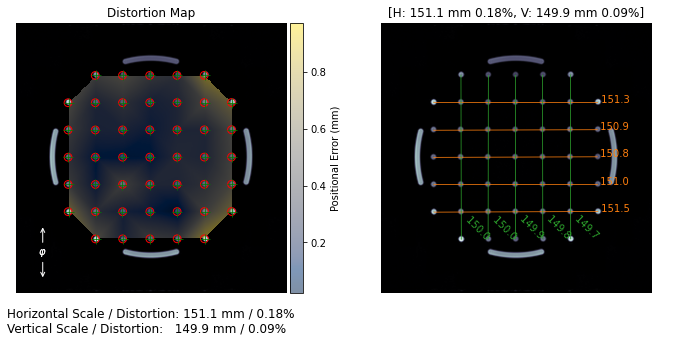

In [10]:
# PIQT: Distortion : SE Axial, Phase AP, 512 matrix (Uncorrected)
seriesno, frame = series['AxialAP_Uncorrected'], slices['AxialAP_Uncorrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = results.append(piqt_distortion_report(dobj, frame=frame))

In [11]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
1504         Axial              RL        0.476                150.069   
1604         Axial              AP        0.476                151.111   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
1504                    0.065              150.945                0.209  
1604                    0.182              149.857                0.090

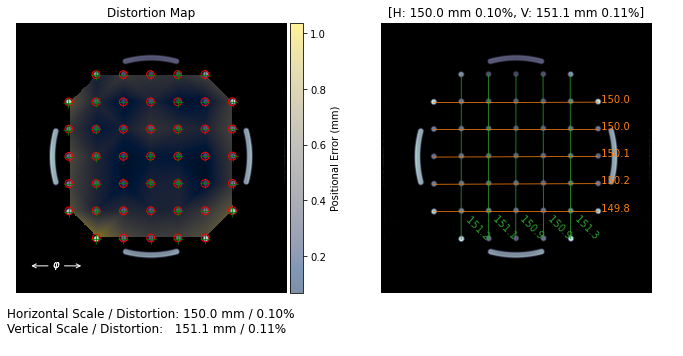

In [12]:
# PIQT: Distortion : SE Axial, Phase RL, 512 matrix (Corrected)
seriesno, frame = series['AxialRL_Corrected'], slices['AxialRL_Corrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = piqt_distortion_report(dobj, frame=frame)

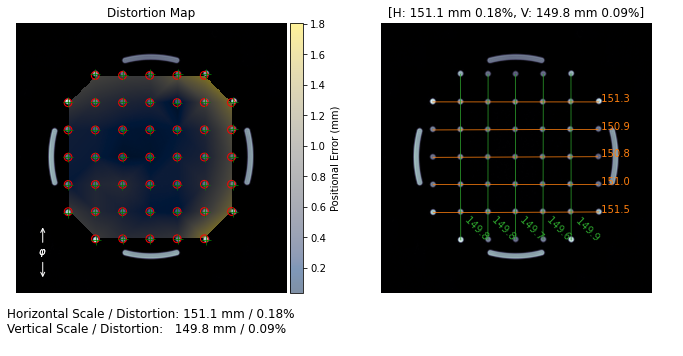

In [13]:
# PIQT: Distortion : SE Axial, Phase AP, 512 matrix (Corrected)
seriesno, frame = series['AxialAP_Corrected'], slices['AxialAP_Corrected']
dobj = fetch_series(patid, studyid, sernos=seriesno, imagesonly=True)[0]
results = results.append(piqt_distortion_report(dobj, frame=frame))

In [14]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
1503         Axial              RL        0.476                150.034   
1603         Axial              AP        0.476                151.076   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
1503                    0.095              151.104                0.112  
1603                    0.179              149.756                0.089

The scale in both the RL and AP directions are well within 1% at the bandwidth used (260Hz/pixel). Whilst not at a level of concern, image scaling and distortion appear to be slightly worse in the FE direction, which could result from $B_0$ or $B_1$ uniformity problems, gradient instability, or ADC errors. It appears unaffected by Philips 2D distortion correction (series 1403, 1503 are uncorrected, series 1404, 1504 are corrected). If this trend continues it may be worth investigating in more detail.

In [15]:
NewPage

## Resolution

Image resolution is estimated by analysis of the MTF block in the PIQT phantom.

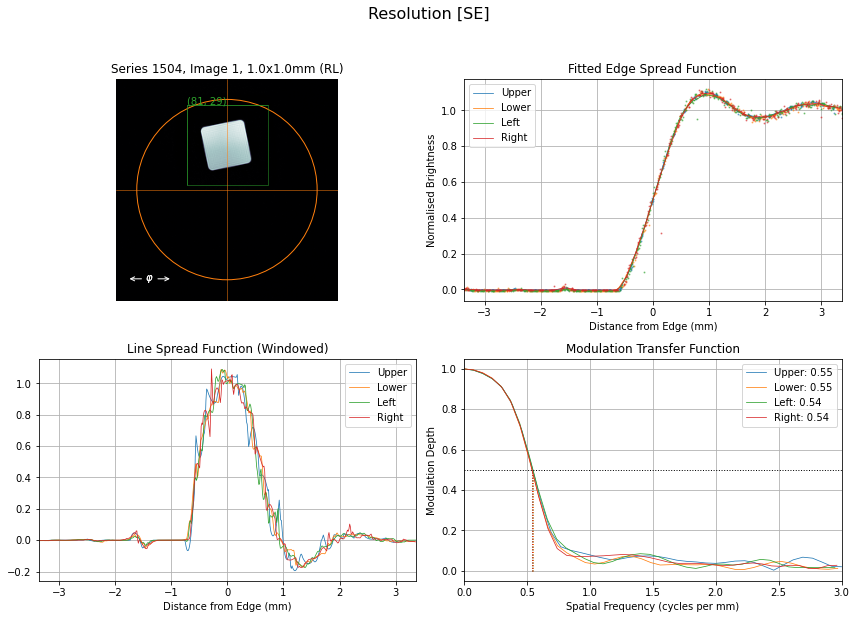

MTF_50
Upper   0.551
Lower   0.545
Left    0.541
Right   0.544

In [30]:
# PIQT: Resolution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
# no 512 acquisition, using 256
dobjs = sorted(fetch_series(patid, studyid, sernos=[series['SE512']], imagesonly=True), key=lambda d: int(d.InstanceNumber))
if len(dobjs) > 1: #accommodate multiframes
    dobj_mtf, dobj_centre = dobjs[slices['MTF']], dobjs[slices['Centre']]
    results = mtf_report(dobj_mtf, dobj_centre)
else:
    results = mtf_report(dobjs[0], mtf_frame=slices['MTF'], centring_frame=slices['Centre'])
plt.show()
results

The MTF_50 is consistent with an image resolution of 1 x 1 mm as is the case here with a `256*256` acquisition.

In [17]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

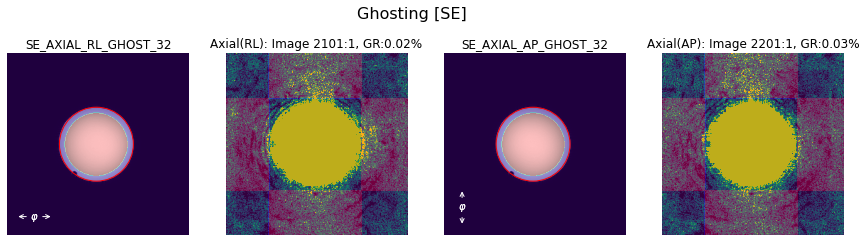

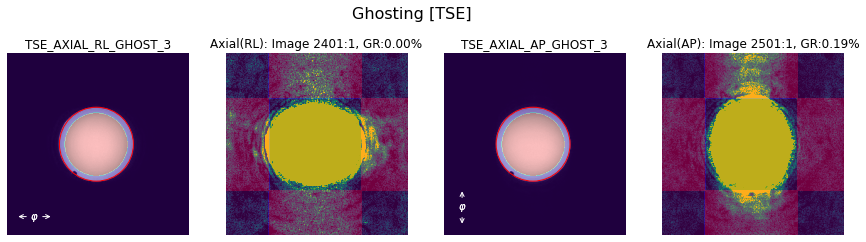

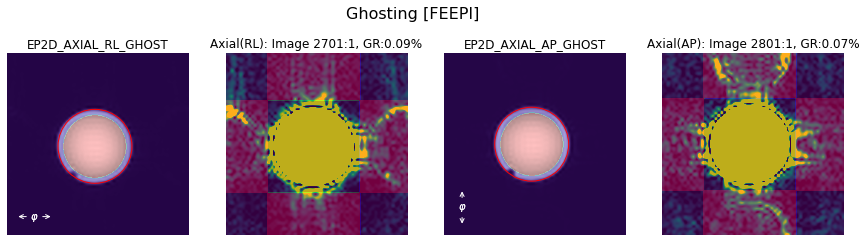

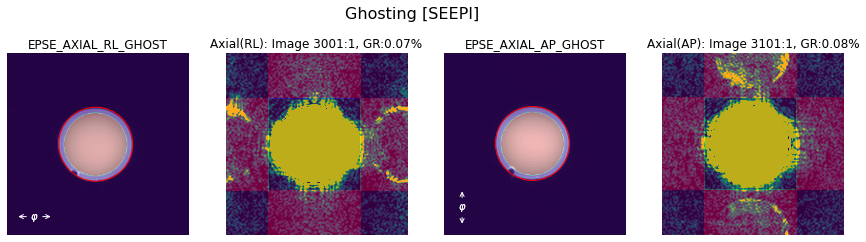

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                      
2101         SE       Axial              RL            0.021
2201         SE       Axial              AP            0.028
2401        TSE       Axial              RL            0.004
2501        TSE       Axial              AP            0.189
2701      FEEPI       Axial              RL            0.091
2801      FEEPI       Axial              AP            0.066
3001      SEEPI       Axial              RL            0.066
3101      SEEPI       Axial              AP            0.079

In [18]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is under 1% for all sequences measured here including the EPIs. The slightly higher level of ghosting seen on the TSE and may be due to amplification of stimulated echo ghosts by the image uniformity filters which could not be completely disabled.

In [19]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the 32 Channel head coil using a spherical phantom filled with silicone oil. Results are presented both before and after `CLEAR` intensity correction.

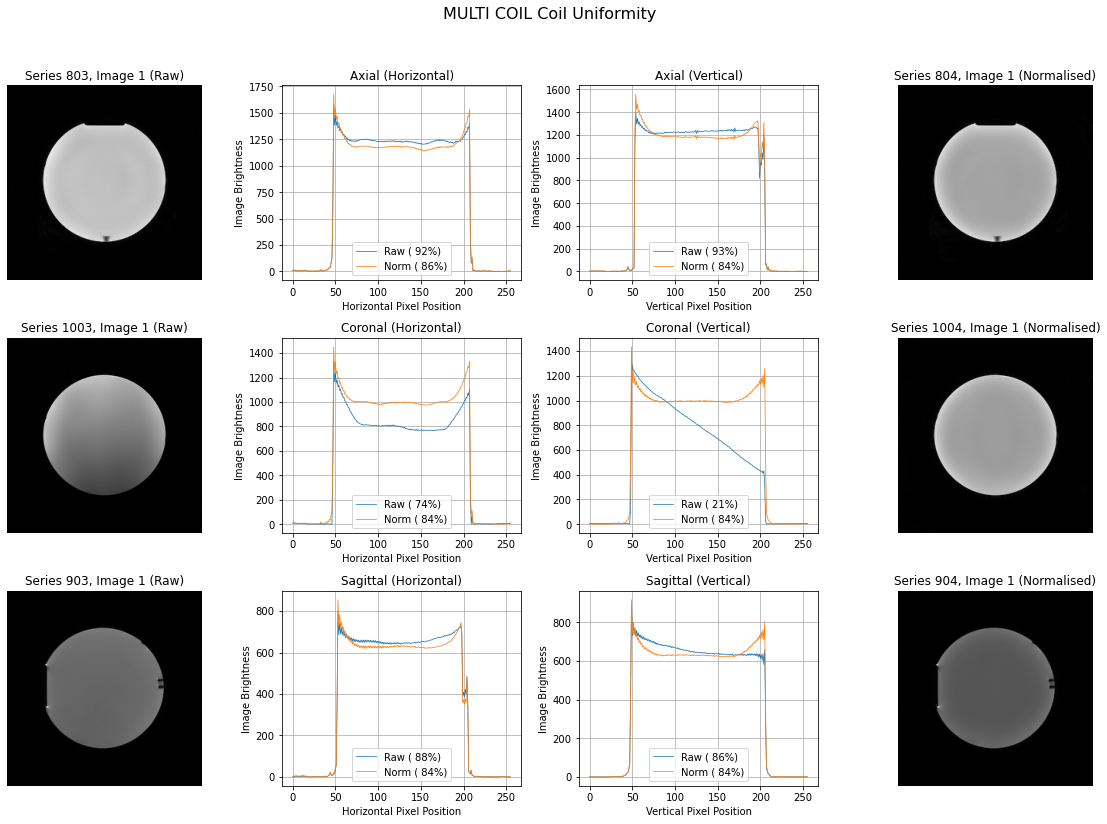

Raw Images


Series No.                              Protocol         Axis  \
Orientation                                                                  
Axial               803  SE_AXIAL_RL_UNIF_OILBOTTLE_32CH_NONE     Axial/RL   
Coronal            1003    SE_COR_FH_UNIF_OILBOTTLE_32CH_NONE   Coronal/RL   
Sagittal            903    SE_SAG_AP_UNIF_OILBOTTLE_32CH_NONE  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    91.93             92.81  
Coronal                  74.07             21.02  
Sagittal                 88.31             85.53

Intensity Normalised Images


Series No.                               Protocol         Axis  \
Orientation                                                                   
Axial               804  SE_AXIAL_RL_UNIF_OILBOTTLE_32CH_CLEAR     Axial/RL   
Coronal            1004    SE_COR_FH_UNIF_OILBOTTLE_32CH_CLEAR   Coronal/RL   
Sagittal            904    SE_SAG_AP_UNIF_OILBOTTLE_32CH_CLEAR  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    86.42             83.66  
Coronal                  83.95             83.65  
Sagittal                 84.42             83.65

In [20]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0], imagesonly=True)
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1], imagesonly=True)
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0], imagesonly=True)
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1], imagesonly=True)
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0], imagesonly=True)
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1], imagesonly=True)

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Philips `CLEAR` intensity correction is adequate in compensating for this.

In [21]:
NewPage

## Signal to Noise

For reference purposes the following is an independent estimate for the standard head/neck coil using the Philips 2L bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

### 20 Channel Head Coil

#### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

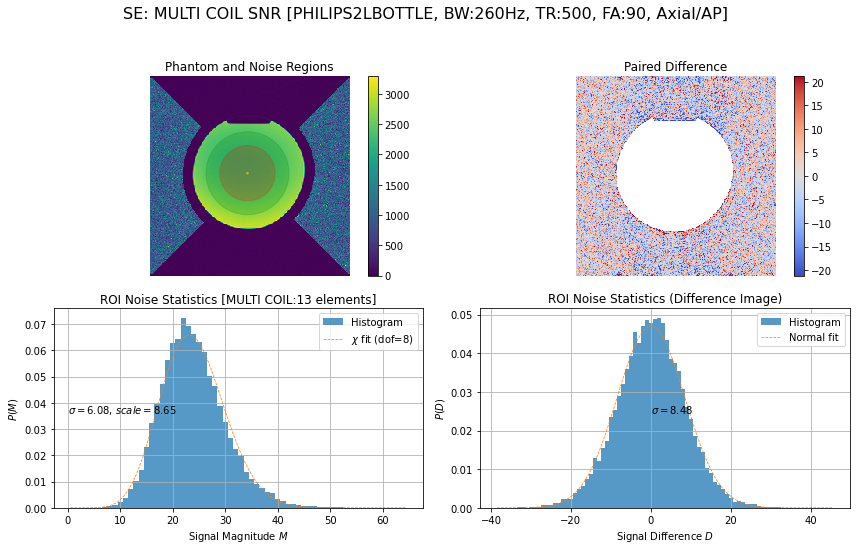

MULTI COIL
0.50       386.8
0.75       399.0

In [22]:
# SNR (uncombined channels)
info = tests['QuarterlySNR_20']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

dobjs = fetch_series(patid, stuid, series['Signal'], imagesonly=True)
assert len(dobjs) == 1
results = snr_report_multi(dobjs, phantom=PHILIPS2LBOTTLE)
plt.show()

with pd.option_context('display.precision', 2):
    display(results)

The noise distribution and SNR values are acceptable. The noise field is notably stable compared to previous instances.

In [23]:
NewPage

### 32 Channel Head Coil

#### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

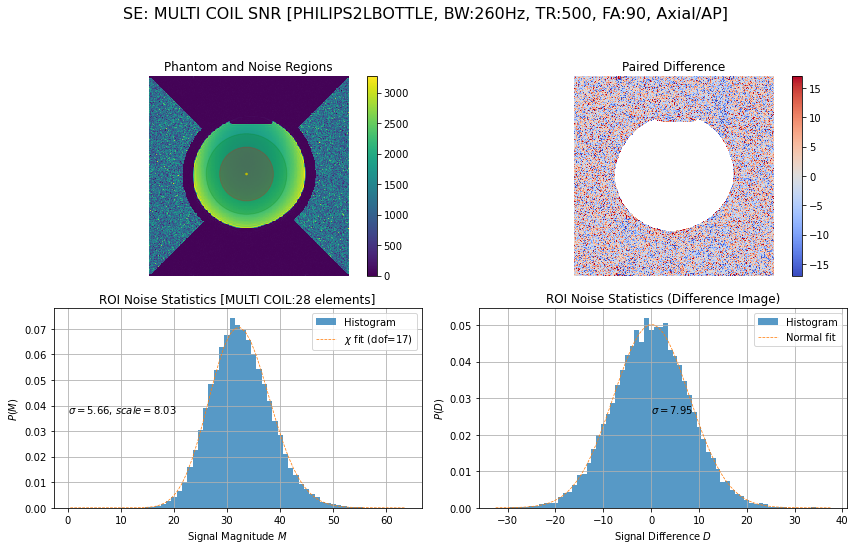

MULTI COIL
0.50      314.39
0.75      337.95

In [24]:
# SNR (uncombined channels)
info = tests['QuarterlySNR_32']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

dobjs = fetch_series(patid, stuid, series['Signal'], imagesonly=True)
assert len(dobjs) == 1
results = snr_report_multi(dobjs, phantom=PHILIPS2LBOTTLE)
plt.show()

with pd.option_context('display.precision', 2):
    display(results)

The noise distribution and SNR values are acceptable. The noise field is notably stable compared to previous instances.

In [25]:
NewPage

## Long Term Stability
The long term stability of an EPI acquisition over a period of 20 minutes. This was performed on a spherical gel filled phantom.

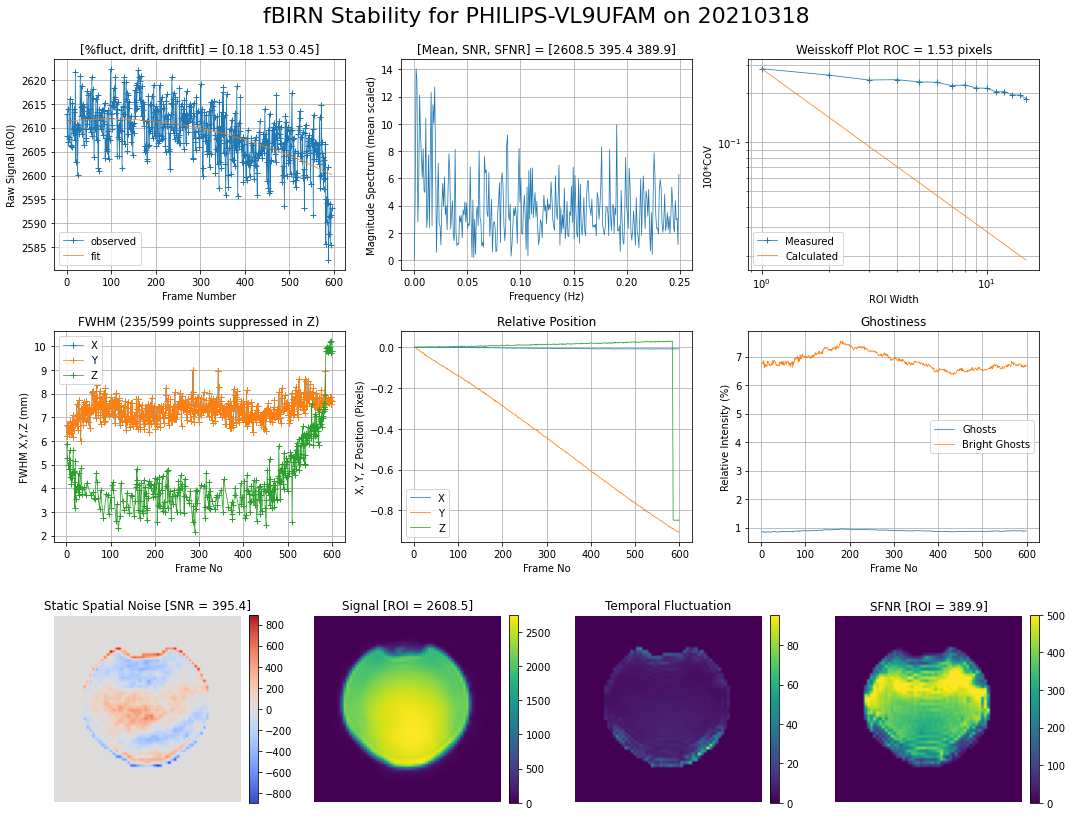

Fluctuations  FittedDrift  Ghosts  BrightGhosts  \
PHILIPS-VL9UFAM_20210318         0.185        0.448   0.887         6.857   

                          SignalMean     SNR     SFNR  
PHILIPS-VL9UFAM_20210318    2608.539  395.39  389.915

In [26]:
# FBIRN Spherical Phantom: Long Term stability
info = tests['Stability']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']

dobjs = fetch_series(patid, studyid, sernos=series['Long_20min'], imagesonly=True)
results = fbirn_full_report(dobjs, maxtimes=599)
plt.show()
results

There are several issues with artefacts that arise towards the end of the run. There is a jump in slice position and a sudden change in gain. This may be the cause of the uneven appearance of the signal to fluctuation noise ratio. We repeat the analysis here using just the first 15 minutes of scanning.

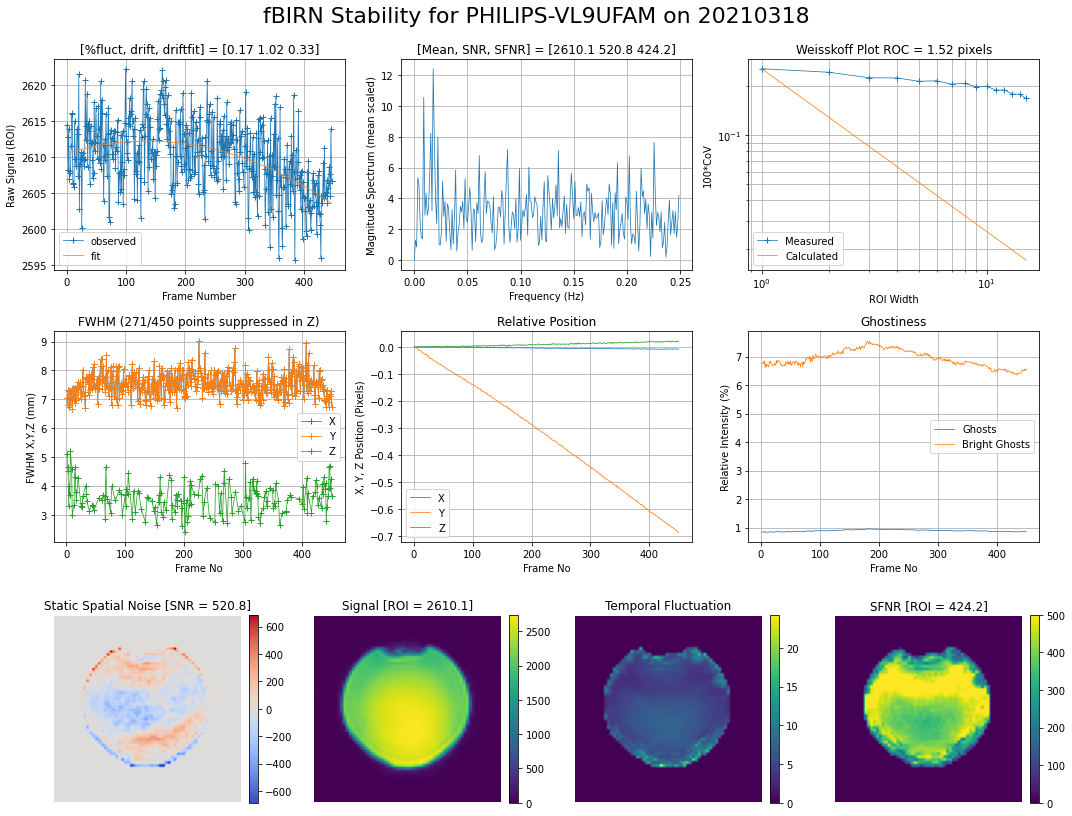

Fluctuations  FittedDrift  Ghosts  BrightGhosts  \
PHILIPS-VL9UFAM_20210318         0.169        0.331   0.892         6.936   

                          SignalMean      SNR     SFNR  
PHILIPS-VL9UFAM_20210318    2610.053  520.767  424.195

In [27]:
# FBIRN Spherical Phantom: Long Term stability
info = tests['Stability']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']

dobjs = fetch_series(patid, studyid, sernos=series['Long_20min'], imagesonly=True)
results = fbirn_full_report(dobjs, maxtimes=450)
plt.show()
results

This has excluded the jumps at the end and the signal drift rate is now small. However, there is still considerable structure in the SFNR images.There are no particularly strong frequency components of concern. Weiskoff analysis shows a very small ROC but this is not concerning in isolation. The positional drift is significant (0.7mm) but steady. Ghosting levels are moderate and reasonably stable.

In [28]:
NewPage

### Frequency Reference
This is the reference value reported in the DICOM header of a localizer scan.

In [29]:
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series)[0]
pd.DataFrame({
    'ImagingFrequency': [larmor_frequency(dobj)]
}, index=['Value']).T

Value
ImagingFrequency  127.749